# Enbloc Imbalanced classification 


The overall workflow is as such:

<ol>
    <li><b>Read about enbloc </b> - Do required readings to figure out the ideal set of features to use.
    <li><b>Read about Imb Class </b> - SMOTE, etc.
    <li><b>Data cleaning</b> - standardize null values, extract tenure date, calculate years to expiry at sale, standardize tenure type, and standardize property type</li>
    <li><b>Merge </b> - merge source_sg and URA datasets together
    <li><b>EDA</b></li>
    <li><b>Dataset creation/feature creation</b></li>
    <li><b>Model training</b> - Semi-supervised anomaly detection (OCSVM, IF, MCD, LOF or imbalanced classification (LR, Ensemble, Boosting, Perceptron). Try PyCaret. </li>
    <li><b>Model performance assessment</b> - evaluate model performance.</li>
   
============================================================================================================================== 

# Articles


## Articles on the En Bloc process

1. [TracyGoh.sg En Bloc Sales Process Guide](https://www.tracygoh.sg/singapore-en-bloc-sales-process-guide/)
2. [ICompareLoan.com](https://www.icompareloan.com/en-bloc-sales-process-guide-singapore/)

## URA/Land Plot Ratio info
1. [PropertyGuru Understand URA master plan (Area plot ratio)](https://www.propertyguru.com.sg/property-guides/how-to-understand-the-ura-master-plan-and-make-your-property-an-investment-24423)
2. [Property Lim Jiu Brothers Plot Ratio](propertylimbrothers.com/insights-posts/what-is-plot-ratio-ura-master-plan)
3. [99.co same thing](https://www.99.co/singapore/insider/ura-master-plan/)

## En Bloc hunting/investing articles
1. [Edgeprop original article](https://www.edgeprop.sg/property-news/how-spot-next-en-bloc)
2. [PropertyGuru Properties in SG with En Bloc potential](https://www.propertyguru.com.sg/property-guides/properties-in-singapore-with-en-bloc-potential-10666)
3. [Stacked Homes - can you actually make money En Bloc hunting?](https://stackedhomes.com/editorial/can-you-make-money-by-buying-property-just-before-its-en-bloc-sale/#gs.5733p2)
4. [Stacked Homes - we analyzed 87 En Bloc Condos](https://stackedhomes.com/editorial/87-en-bloc-condos/#gs.5u6wrl)

## Imb classification/anomaly detection articles
1. [MLM Tour of Imb metrics for classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)
2. [MLM SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
3. [MLM Anomaly Detection/One Class Classification](https://machinelearningmastery.com/one-class-classification-algorithms/)

# Analysis

## Edgeprop model


* `tenure` (binary)
* `project age`
* `#units`
* `location` (binary - 1 for central and 0 for non-central)
* `enhancement` (binary) - if current GPR < prevailing URA masterplan GPR (how to add as feature after model? rule based. ask Patrick) - GFA = GPR x plot area. How do we find the __current GPR__ for both current projects and past enbloc projects? 
* `premium` - ???

__Main factors__ - age (old units do better), #units (doesn't seem like much) , enhancement (the GPR increased) , premium.


## PropertyGuru Potential En Bloc in 2021

1. Braddell View (Bishan) - need to impute/fill in the lease_type in `final`.
2. Emerald Park (Commonwealth)
3. Hillcrest Arcadia (Novena)
4. Peace Mansions (RV)

_Sanity check_ - Identified as top candidates. Can try and check probabilities of these that the model generates as a 'sanity check`.

_Their factors (ideas for model features)_ 
1. __The Value of Land and Property in Your Area Have Gone Up Significantly__ (e.g new MRT, etc). How to quantify this/make this a feature? Some kind of area level index - regional level index. Possible - number of new projects, if MRT.
2. __Not using full plot ratio__ - the property inside the plot is less than the maximum GPR - How to calculate/quantify?
3. __Tenure__ - older properties with older tenure are more attractive to developer.


## StackedHomes En Bloc Condo analysis

They analyzed from 87 En bloc condos (2016-2019) and plotted:
1. distribution of district (9,10,11)
2. distribution of tenure type (more freehold)
3. distribution of age (30 years and above)
4. distribution of units (<100 units - smaller units favored)
5. distribution of distance to MRT if 10 mins or less.

Some ideas for EDA. However they did not bother to divide by proportion, so might want to try that. E.g $$A_i = \frac{E_i}{T_i}, i \in D$$

## Stackedhomes Can you make money from EnBloc hunting in 2021?

__DC increase in 2017__ - Development charge rates (developer must pay DC) which will drive their offer prices down. DC is URA mandated and location based (Geographical sectors and use groups). Revised every 6 months. Data here - [URA DC rates](https://www.ura.gov.sg/Corporate/Guidelines/Development-Control/Planning-Permission/Folder/DC-Charge-Rates). Can we make DC a feature? E.g lower DCs in certain sectors might influence en bloc.

`Rate of DC change in sector`.

Must get data of historical rate of change of DC for each sector over years.<br>
__ABSD increase in 2018__ - Increased ABSD. Developers get 25% remittance on duty if project completed in 5 years. So this might drive large projects demand down. check against #units.

Might see en bloc developers want properties that have low DC and are small.

## TLDR - new feature ideas:

* Enhancement feature. For each project, a single float/int of $E = GPR_{URA}/GPR_{actual}$. We need to calculate the actual GPR, and lookup the corresponding URA GPR. If high, then prime en bloc.
* Regional valuation feature - For each project, % regional value change over last (5/4/3/2/1 years). If high, then prime en bloc.
* DC feature - For each project, % change of DC value over last year. if negative, then higher chance of en bloc.

However these features may only be available to negative labels (current properties in `VB`) and so we have to use some kind of manual rule based classification using these features after the main model, unless we can somehow get these features for all the historical en bloc.

# Setup

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import math
import statistics
import os
import re
from datetime import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import config as config
from rea_python.main.database import DBCopyMode, RedshiftHook
from rea_python.constants import OutputFormat

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

sql_path = os.path.join(os.path.dirname(os.path.realpath('EnblocImbClass.ipynb')), 'sql')

# initialize redshift hook
src_hook = RedshiftHook(iam_role_arn=config.IAM_ROLE_ARN,
                        via_s3_bucket=config.REDSHIFT_HOOK_BRIDGE_BUCKET,
                        via_s3_folder=config.REDSHIFT_HOOK_BRIDGE_FOLDER)

# set up connection
src_hook.set_conn_from_uri(config.DATA_WAREHOUSE_URI)

# load queries from sql
src_hook.load_queries_from_folders([sql_path])
df = src_hook.execute_loaded_query(query_name='data_query', output_format=OutputFormat.pandas)


Channel Hook not found in environment variables, not sending error logs to Teams. To enable it, please set up `TEAMS_CHANNEL_HOOK` in the environment. 
2021-08-10 11:30:19,268 : rea_python.config.ConfigHandler : INFO : Reading config file from C:\Users\RyanChew/.rpc.cfg
2021-08-10 11:30:19,268 : rea_python.config.ConfigHandler : WARNING : Config file not found. Please make a copy at ~/.rpc.cfg and try again. Loading the object as None. Any operation that requires config object will encounter exceptions. 
`geo` extra is not installed. Geo related packages will be unavailable. 
Channel Hook not found in environment variables, not sending error logs to Teams. To enable it, please set up `TEAMS_CHANNEL_HOOK` in the environment. 
2021-08-10 11:30:20,456 : rea_python.main.database.RedshiftHook : WARNING : S3 configuration is needed for any bulk write operation. 
Instantiating S3 hooks for bucket dev-misc-usage, please check you have valid AWS credentials access in the `~/.aws/credentials` fi

# Data stuff

* Load data and standardize names

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3292 entries, 0 to 3291
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latitude             3104 non-null   float64
 1   longitude            3104 non-null   float64
 2   km_to_sg_cbd         3104 non-null   float64
 3   lot_size_sqft        3100 non-null   float64
 4   project_name         3292 non-null   object 
 5   project_age          3024 non-null   float64
 6   postal_code          3288 non-null   object 
 7   region               3288 non-null   object 
 8   zone                 3288 non-null   object 
 9   property_type_group  3292 non-null   object 
 10  num_of_units         3286 non-null   float64
 11  lease_type           2992 non-null   object 
 12  approx_project_gfa   3186 non-null   float64
 13  avg_area_sqft        3186 non-null   float64
 14  plot_ratio           17 non-null     float64
 15  potential_gfa        10 non-null     f

## Nulls

In [3]:

#need to fill in the missing PropertyGuru benchmark properties so they don't get dropped
df.lease_type[df.project_name == 'BRADDELL VIEW'] = 'leasehold'
df.lease_type[df.project_name == 'HILLCREST ARCADIA'] = 'leasehold'

enbloc_df = df[df['enbloc'] == 1]
nonenbloc_df = df[df['enbloc'] == 0]
condo_df = df[df['property_type_group'] == 'condo']
landed_df = df[df['property_type_group'] == 'landed']
condo_df['lot_size_num_units_ratio'] = condo_df.lot_size_sqft/condo_df.num_of_units
landed_df['lot_size_num_units_ratio'] = landed_df.lot_size_sqft/landed_df.num_of_units

##########################################################################################################

enbloc_nulls = -(enbloc_df.count() - enbloc_df.shape[0])
nonenbloc_nulls = -(nonenbloc_df.count() - nonenbloc_df.shape[0])

df[(df.project_name == 'HILLCREST ARCADIA')|(df.project_name == 'EMERALD PARK')|
             (df.project_name == 'BRADDELL VIEW')|(df.project_name == 'BALMORAL PLAZA')]

latitude  longitude  km_to_sg_cbd  lot_size_sqft       project_name  \
36     1.33992    103.841       6333.48       5335.900      BRADDELL VIEW   
447    1.33378    103.809       7294.19       3816.360  HILLCREST ARCADIA   
455    1.28948    103.830       2455.28       1529.470       EMERALD PARK   
3136   1.31643    103.835       4026.54        385.027     BALMORAL PLAZA   

      project_age postal_code          region         zone  \
36           40.0      579732  central region    toa payoh   
447          41.0      289850  central region  bukit timah   
455          28.0      169586  central region  bukit merah   
3136         27.0      259708  central region       newton   

     property_type_group  num_of_units lease_type  approx_project_gfa  \
36                 condo         931.0  leasehold           1519760.0   
447                condo         285.0  leasehold            513063.0   
455                condo         280.0  leasehold            303688.0   
3136               condo           7.0   freehold             14228.0   

      avg_area_sqft  plot_ratio  potential_gfa  enbloc categorical_enbloc  
36           1632.0         NaN            NaN       0             enbloc  
447          1800.0         NaN            NaN       0             enbloc  
455          1084.0         NaN            NaN       0             enbloc  
3136         2032.0         NaN            NaN       0             enbloc

In [4]:
enbloc_nulls

latitude               184
longitude              184
km_to_sg_cbd           184
lot_size_sqft          187
project_name             0
project_age            230
postal_code              0
region                   0
zone                     0
property_type_group      0
num_of_units             0
lease_type               0
approx_project_gfa       0
avg_area_sqft            0
plot_ratio             425
potential_gfa          432
enbloc                   0
categorical_enbloc       0
dtype: int64

In [5]:
nonenbloc_nulls

latitude                  4
longitude                 4
km_to_sg_cbd              4
lot_size_sqft             5
project_name              0
project_age              38
postal_code               4
region                    4
zone                      4
property_type_group       0
num_of_units              6
lease_type              298
approx_project_gfa      106
avg_area_sqft           106
plot_ratio             2850
potential_gfa          2850
enbloc                    0
categorical_enbloc        0
dtype: int64

For enbloc, the main limiting factor is project age.

## EDA

See tableau workbook.

<AxesSubplot:xlabel='lot_size_num_units_ratio', ylabel='Probability'>

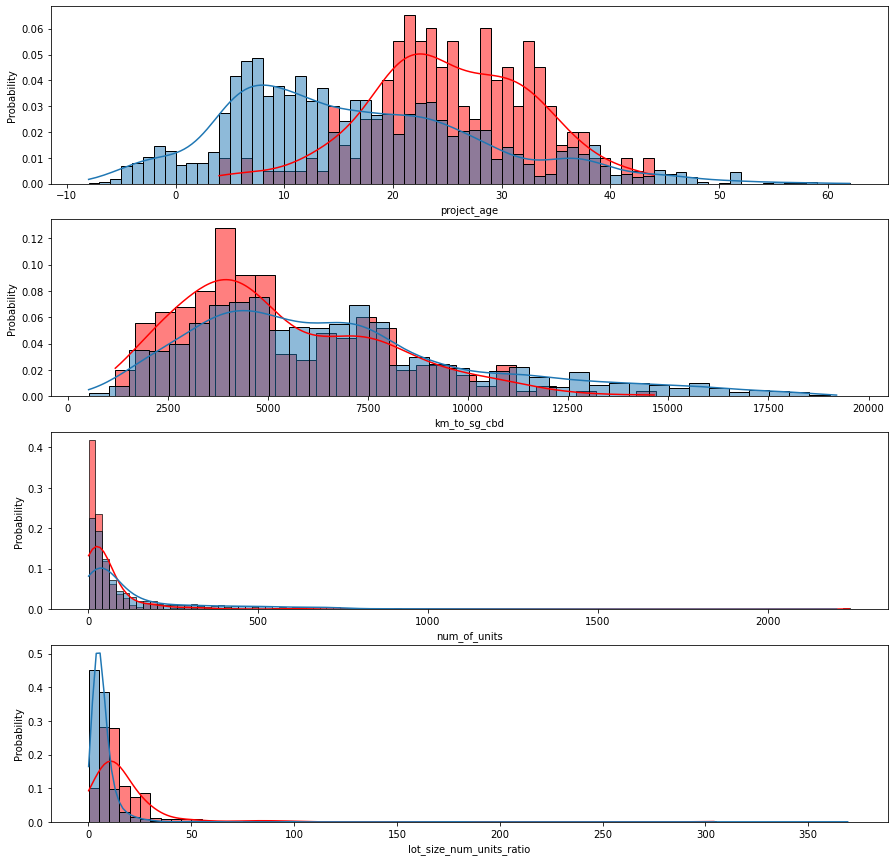

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(15,15))
sns.histplot(condo_df.dropna(subset=['project_age'])[condo_df.enbloc==True], x='project_age', stat='probability', kde='1',binwidth=1,ax=ax1,color='red')
sns.histplot(condo_df.dropna(subset=['project_age'])[condo_df.enbloc==False], x='project_age', stat='probability', kde='1',binwidth=1,ax=ax1)
sns.histplot(condo_df.dropna(subset=['km_to_sg_cbd'])[condo_df.enbloc==True], x='km_to_sg_cbd', stat='probability', kde='1',binwidth=500,ax=ax2,color='red')
sns.histplot(condo_df.dropna(subset=['km_to_sg_cbd'])[condo_df.enbloc==False], x='km_to_sg_cbd', stat='probability', kde='1',binwidth=500,ax=ax2)
sns.histplot(condo_df.dropna(subset=['num_of_units'])[condo_df.enbloc==True], x='num_of_units', stat='probability', kde='1',binwidth=20,ax=ax3,color='red')
sns.histplot(condo_df.dropna(subset=['num_of_units'])[condo_df.enbloc==False], x='num_of_units', stat='probability', kde='1',binwidth=20,ax=ax3)
sns.histplot(condo_df.dropna(subset=['lot_size_num_units_ratio'])[condo_df.enbloc==True], x='lot_size_num_units_ratio', stat='probability', kde='1',binwidth=5,ax=ax4,color='red')
sns.histplot(condo_df.dropna(subset=['lot_size_num_units_ratio'])[condo_df.enbloc==False], x='lot_size_num_units_ratio', stat='probability', kde='1',binwidth=5,ax=ax4)


<AxesSubplot:xlabel='lot_size_num_units_ratio', ylabel='Probability'>

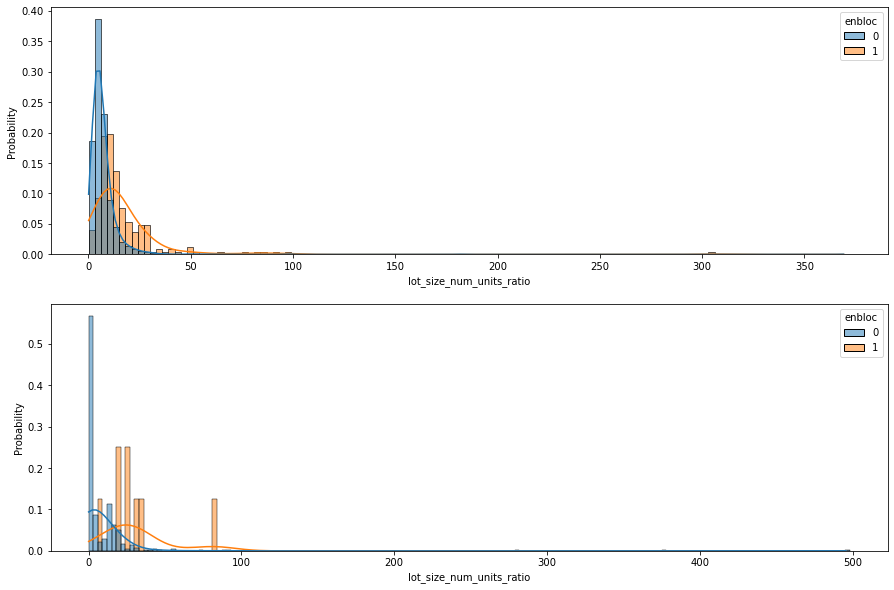

In [7]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(15,10))
sns.histplot(condo_df.dropna(subset=['num_of_units']), x='lot_size_num_units_ratio', hue='enbloc',common_norm=0,stat='probability', kde='1',binwidth=3,ax=ax1)
sns.histplot(landed_df.dropna(subset=['num_of_units']), x='lot_size_num_units_ratio', hue='enbloc',common_norm=0,stat='probability', kde='1',binwidth=3,ax=ax2)


## Imputation/dropping

* Impute - continuous variables because $\mathscr{I'm - LAZY}$
* Drop - `lease_type`, `approx_gfa_sqft`, `avg_area_sqft`
* [6 different ways to impute towardsdatascience.com](https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779)

In [8]:


def preprocess(df, cols, dummies):
    #dropna
    df.dropna(subset=['lease_type','approx_project_gfa','avg_area_sqft','region','zone'], inplace=True)
    df = df.loc[:,['project_name','km_to_sg_cbd','lot_size_sqft','project_age','num_of_units','approx_project_gfa','lot_size_num_units_ratio','avg_area_sqft','region','zone','lease_type','enbloc']]
    #impute mean
    for col in cols:
        df[col] = df[col].fillna(value = df[col].mean()) 
    #get dummies
    df = pd.get_dummies(df, columns=dummies)
    names = df.project_name
    ndf = df.loc[:,['project_name','project_age','num_of_units','lot_size_num_units_ratio','approx_project_gfa']]
    df = df.drop('project_name',axis=1)
    enbloc = df.enbloc
    x = df.loc[:, df.columns != 'enbloc']
    return df, names, enbloc, x, ndf

cols = ['project_age','km_to_sg_cbd','lot_size_sqft','num_of_units','lot_size_num_units_ratio']
dummies = ['region','zone','lease_type']

cdf, cnames, cenbloc, cx, cndf = preprocess(condo_df,cols,dummies)
ldf, lnames, lenbloc, lx, lndf = preprocess(landed_df,cols,dummies)

# Model 

* The lower the train split, the higher the probabilities of nonenblocs classified as enbloc. 

## PyCaret Condo

In [9]:
from pycaret.classification import *

ccaret = setup(data=cdf, target='enbloc', 
                    train_size=0.7, preprocess=False,
                    fix_imbalance=True,
                    data_split_stratify=True,
                    transformation=True,
                    normalize=True,
                    normalize_method='robust',
                    session_id=2)

c10 = compare_models(n_select=10, sort='AUC')
cr = pull()
cmodel_names = cr.index.values

In [10]:
def make_results(model_names, model_list, x, names, enbloc, ndf):
    
    pred = lambda model:pd.DataFrame(model.predict_proba(x)).iloc[:,1]
    models = list(map(pred,model_list))
    
    data = {"project_name": pd.DataFrame(names.values),
            "enbloc": pd.DataFrame(enbloc.values),
            f"{model_names[0]}": models[0],
            f"{model_names[1]}": models[1],
            f"{model_names[2]}": models[2],
            f"{model_names[3]}": models[3],
            f"{model_names[4]}": models[4],
            f"{model_names[5]}": models[5],
            f"{model_names[6]}": models[6],
            f"{model_names[7]}": models[7],
           }

    results = pd.concat(data,axis=1)
    model_results = results.iloc[:,2:]
    results['average'] = model_results.mean(numeric_only=True, axis=1)
    results.columns = results.columns.droplevel(1)
    results = results.sort_values('average', ascending = False)
    results['proportion'] = results.enbloc.sum()/results.shape[0]
    return results.merge(ndf, on='project_name', how='left')



condo_results = make_results(cmodel_names ,c10, cx, cnames, cenbloc, cndf)
pd.options.display.float_format = '{:,.3f}'.format

## Results

* These are the properties that PropertyGuru said had higher chance of Enbloc.

In [11]:
condo_results[(condo_results.project_name == 'HILLCREST ARCADIA')|(condo_results.project_name == 'EMERALD PARK')|
             (condo_results.project_name == 'BRADDELL VIEW')|(condo_results.project_name == 'PEACE CENTRE/MANSIONS')]

project_name  enbloc  lightgbm   gbc    rf   ada    et    dt  \
691   PEACE CENTRE/MANSIONS       0     0.003 0.087 0.060 0.491 0.000 0.000   
1340          BRADDELL VIEW       0     0.018 0.016 0.170 0.452 0.130 0.000   
1606           EMERALD PARK       0     0.000 0.020 0.000 0.466 0.000 0.000   
1796      HILLCREST ARCADIA       0     0.001 0.037 0.070 0.468 0.000 0.000   

        nb   lda  average  proportion  project_age  num_of_units  \
691  0.389 0.399    0.179       0.176       44.000        42.000   
1340 0.000 0.107    0.112       0.176       40.000       931.000   
1606 0.041 0.267    0.099       0.176       28.000       280.000   
1796 0.000 0.152    0.091       0.176       41.000       285.000   

      lot_size_num_units_ratio  approx_project_gfa  
691                     15.727         128,908.000  
1340                     5.731       1,519,760.000  
1606                     5.462         303,688.000  
1796                    13.391         513,063.000

In [12]:
condo_results[condo_results.enbloc==0]

project_name  enbloc  lightgbm   gbc    rf   ada    et    dt  \
222               ESPANA       0     1.000 0.984 0.770 0.527 0.720 1.000   
301   PALM GROVE REGENCY       0     0.884 0.522 0.560 0.504 0.720 1.000   
313            GRANGE 80       0     0.998 0.810 0.680 0.499 0.720 1.000   
322     MANDALAY MANSION       0     0.960 0.880 0.620 0.516 0.470 1.000   
360            GRANGE 70       0     0.618 0.464 0.570 0.504 0.680 1.000   
...                  ...     ...       ...   ...   ...   ...   ...   ...   
2417       INZ RESIDENCE       0     0.000 0.002 0.000 0.154 0.000 0.000   
2418          WANDERVALE       0     0.000 0.002 0.000 0.154 0.000 0.000   
2419       PARC CANBERRA       0     0.000 0.002 0.000 0.154 0.000 0.000   
2420         LAKE GRANDE       0     0.000 0.002 0.000 0.160 0.000 0.000   
2421           SOL ACRES       0     0.000 0.002 0.000 0.154 0.000 0.000   

        nb   lda  average  proportion  project_age  num_of_units  \
222  0.525 0.289    0.727       0.176       16.869        11.000   
301  0.855 0.405    0.681       0.176       19.000        20.000   
313  0.328 0.354    0.674       0.176       21.000        10.000   
322  0.535 0.293    0.659       0.176       16.869        25.000   
360  0.572 0.484    0.612       0.176       22.000        20.000   
...    ...   ...      ...         ...          ...           ...   
2417 0.000 0.026    0.023       0.176        2.000       497.000   
2418 0.000 0.026    0.023       0.176        3.000       534.000   
2419 0.000 0.023    0.022       0.176       -5.000       496.000   
2420 0.000 0.016    0.022       0.176        1.000       710.000   
2421 0.000 0.008    0.021       0.176        3.000     1,327.000   

      lot_size_num_units_ratio  approx_project_gfa  
222                     22.909          14,164.000  
301                     51.413         226,334.000  
313                     11.059          13,313.000  
322                      5.971          56,312.000  
360                      9.134          52,405.000  
...                        ...                 ...  
2417                     3.063         524,916.000  
2418                     3.316         582,844.000  
2419                     3.379         491,653.000  
2420                     2.330         546,685.000  
2421                     2.304       1,231,680.000  

[1992 rows x 16 columns]

## Histograms of results

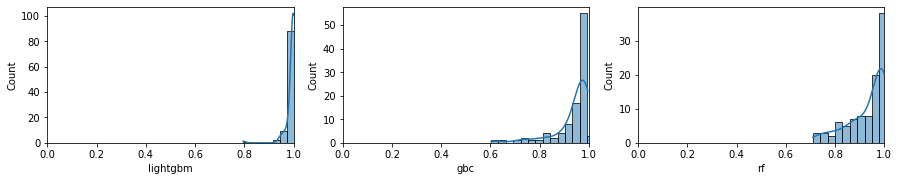

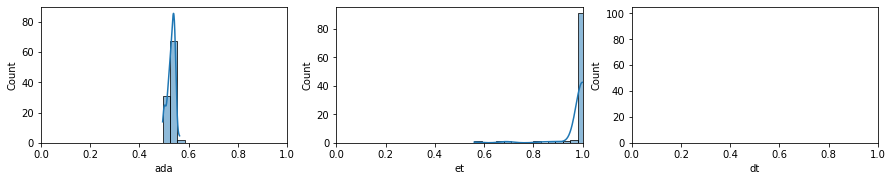

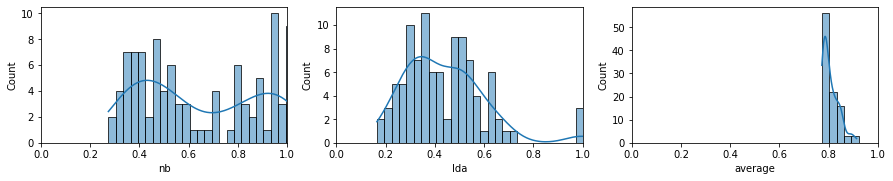

In [13]:

def histies(df, features):
    for i in range(len(features)):
        if i % 3 == 0:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 2.5))
            ax1.set_xlim(0,1)
            ax2.set_xlim(0,1)
            ax3.set_xlim(0,1)
            sns.histplot(df, x=features[i],stat='count', kde='1',binwidth=0.03,ax=ax1)

        elif i % 3 == 1:
            sns.histplot(df, x=features[i],stat='count', kde='1',binwidth=0.03,ax=ax2)
        else:
            sns.histplot(df, x=features[i],stat='count', kde='1',binwidth=0.03,ax=ax3)    
    plt.show()
    
    
features = condo_results.columns[2:11]    
histies(condo_results.head(100), features)

# Feature importances

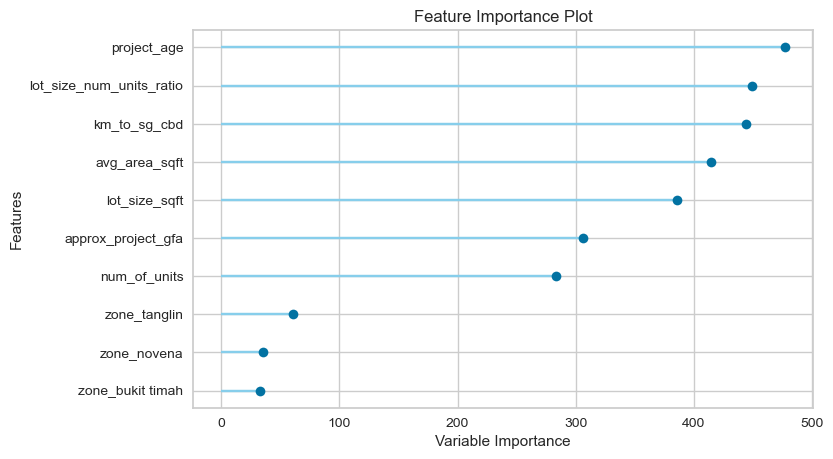

In [14]:
plot_model(c10[0],'feature')

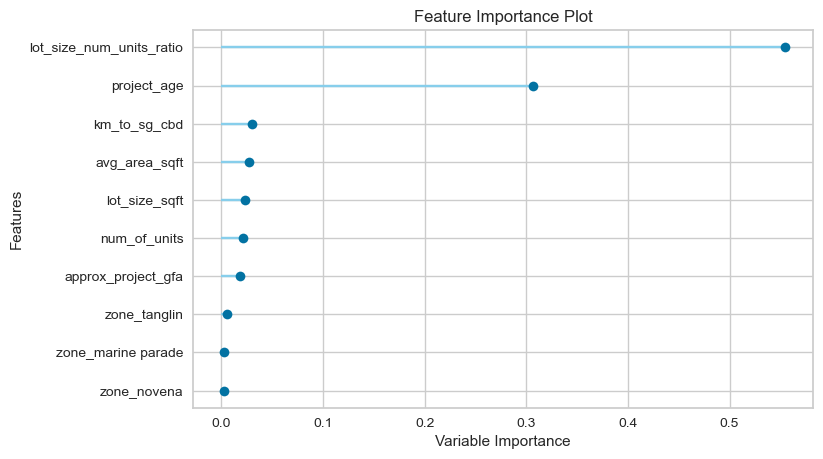

In [15]:
plot_model(c10[1],'feature')

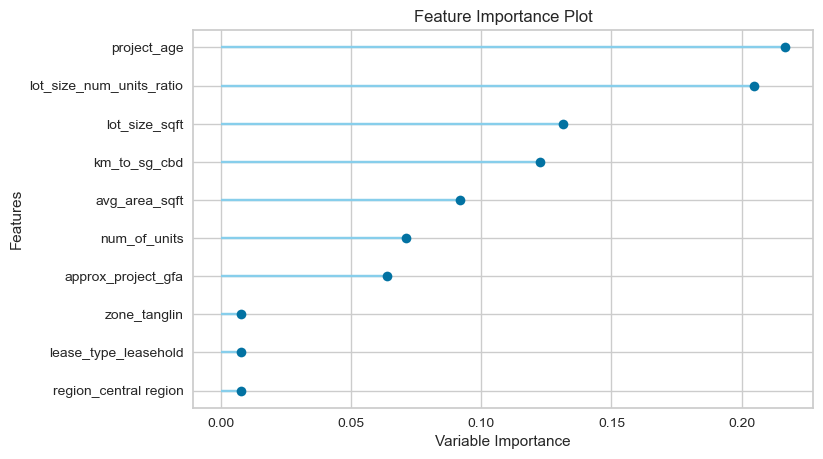

In [16]:
plot_model(c10[2],'feature')

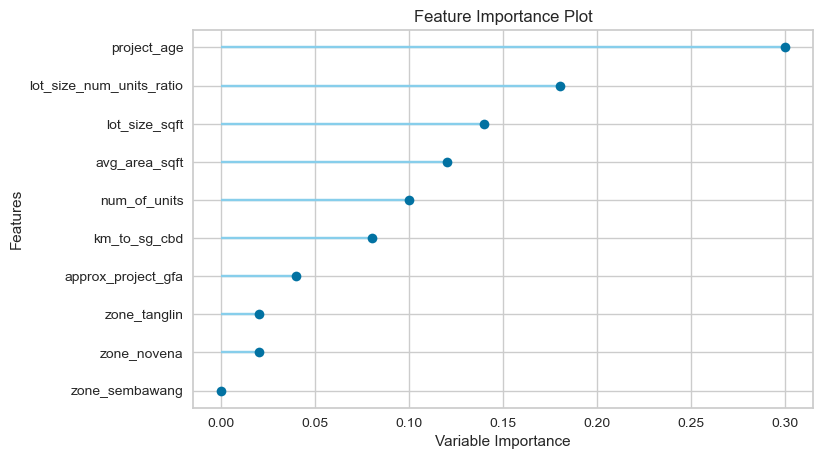

In [17]:
plot_model(c10[3],'feature')

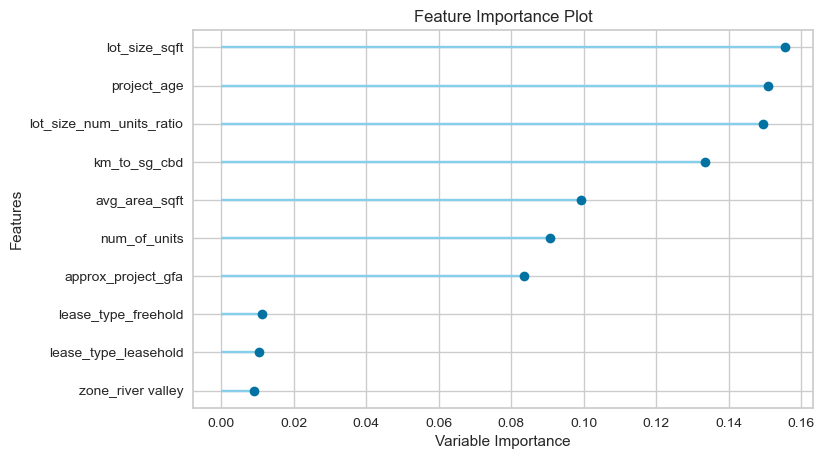

In [18]:
plot_model(c10[4],'feature')

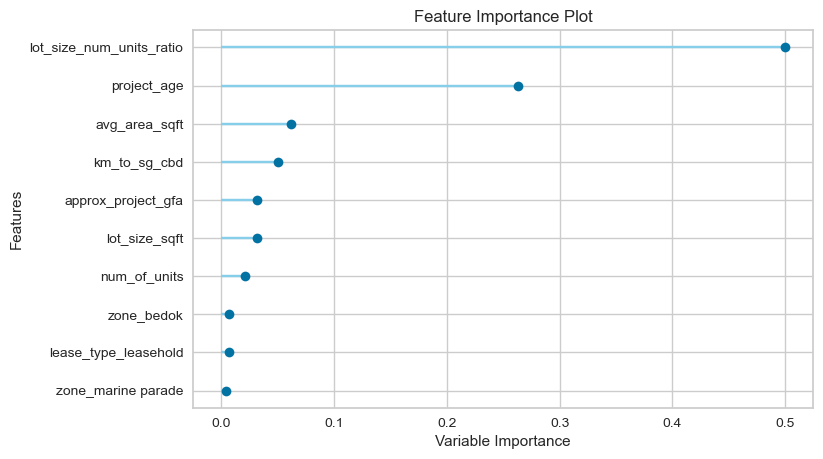

In [19]:
plot_model(c10[5],'feature')

# KL/JS(P||Q), SHAP values

1. Match domains. Add two 'fake samples' extend the shorter distribution to match the domain of the longer one.
2. Calculate the KDE from the empirical distribution.
3. Sample n points from the KDE. Say `n=500`.
4. Evaluate the pdfs with `evaluate`. This forms a discrete pdf vector.
5. Compute the Jensen Shannon distance with the two discrete pdf vectors. This is a scalar, positive real valued number.

Sadly doesn't correlate with feature importance at all ... 

In [20]:
from scipy.spatial import distance
from scipy.stats import gaussian_kde

def js(x0,x1):

    gmin, gmax = min(x0.min(),x1.min()),max(x0.max(),x1.max())
    
    if gmin < x0.min():
        x0 = np.append(x0,[gmin])
    if gmin < x1.min():
        x1 = np.append(x1,[gmin])
    if gmax > x0.max():
        x0 = np.append(x0,[gmax])
    if gmax > x1.max():
        x1 = np.append(x1,[gmax])
        
    k0, k1 = gaussian_kde(x0), gaussian_kde(x1)
    s0, s1 = k0.resample(size=1000, seed=1), k1.resample(size=1000, seed=1)    
    v0, v1 = k0.evaluate(s0), k1.evaluate(s1)
    return distance.jensenshannon(v0,v1)
 
def compute_distances(df):
    
    df = df.iloc[:,0:8]
    f = lambda df,i: df[df.enbloc==i]
    df0, df1 = f(df,0), f(df,1)

    cols = df.columns[:-1]
    
    distance_list = []
    for col in cols:
        x0, x1 = df0[col], df1[col]
        jsd = js(x0, x1)
        distance_list.append(jsd)
        
    jsdf = pd.DataFrame(pd.Series(data=distance_list, index=cols),columns=['JS-distance']).reset_index().sort_values('JS-distance', ascending=0)
    return jsdf
        
landedjs = compute_distances(ldf)
condojs = compute_distances(cdf)
    

<AxesSubplot:xlabel='index', ylabel='JS-distance'>

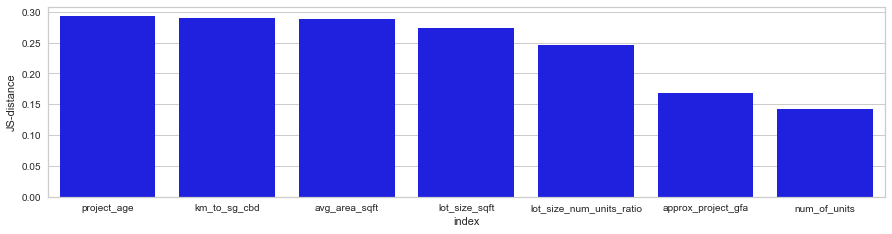

In [21]:
fig,ax= plt.subplots(figsize=(15,3.5))
sns.barplot(x=condojs['index'], y='JS-distance', data=condojs, color='blue')

<AxesSubplot:xlabel='index', ylabel='JS-distance'>

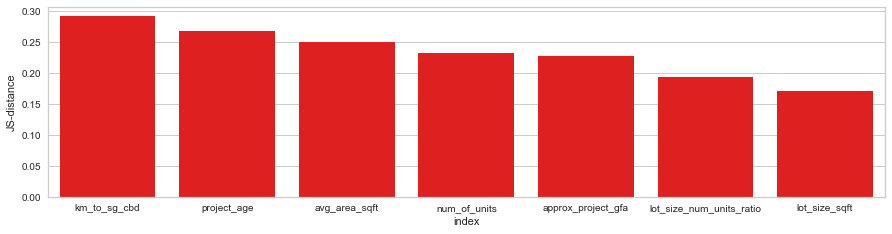

In [22]:
fig,ax= plt.subplots(figsize=(15,3.5))
sns.barplot(x= landedjs['index'], y='JS-distance', data=landedjs, color='red')

<AxesSubplot:xlabel='index'>

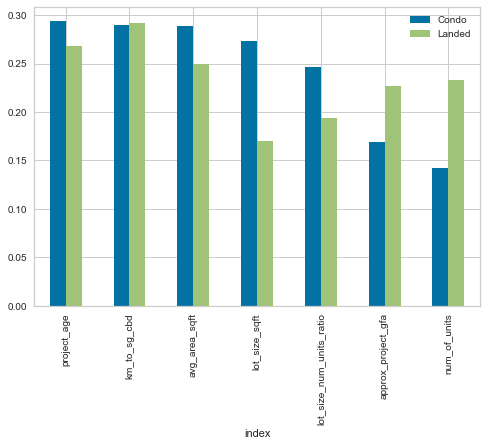

In [23]:
pd.concat({
    'Condo': condojs.set_index('index')['JS-distance'], 'Landed': landedjs.set_index('index')['JS-distance']
}, axis=1).plot.bar()

# Clustering method

We will use clustering to group into clusters. Then, naively, the $p(enbloc|cluster_i)$ = ratio of nonenblocs to enblocs in said cluster.

This gives us a second probability that we can use in addition to the Pycaret output.

Need to figure out how we integrate the output of the clustering into the thing.

1. k-means
2. aggl. clust
3. spectral clust
4. GMM
5. DBScan (this is a disaster so no go)

Other:

1. K-medoids (outlier robust)


In [34]:
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

def cluster(x, ndf, clusters, results):
    '''
    args:
    x:        pd.DataFrame. The df of x values.
    ndf:      pd.DataFrame. The df of property names. One of 'cndf', 'lndf'.
    clusters: int. Num of clusters. 
    results:  pd.DataFrame. The df of the original results.
    
    '''
    x = x.loc[:,['km_to_sg_cbd','lot_size_sqft','project_age','num_of_units','approx_project_gfa','lot_size_num_units_ratio','avg_area_sqft', 'lease_type_freehold','lease_type_leasehold']]
    x = PowerTransformer().fit_transform(x)
    x = pd.DataFrame(x, index=ndf.index)
    
    km = pd.Series(KMeans(n_clusters=clusters, random_state=0).fit_predict(x), index=ndf.project_name)
    aggl = pd.Series(AgglomerativeClustering(n_clusters=clusters).fit_predict(x), index=ndf.project_name)
    gmm = pd.Series(GaussianMixture(n_components=clusters, random_state=0).fit_predict(x), index=ndf.project_name)
    
    clusters = pd.concat({'km':km, 'aggl':aggl, 'gmm':gmm}, axis=1).reset_index()  
    results = results.merge(clusters, on='project_name', how='left')
    
    group = lambda feature: results.groupby(feature)['enbloc'].transform('mean')
    
    results['kmprob'] = group('km')
    results['agglprob'] = group('aggl')
    results['gmmprob'] = group('gmm')
    results['cluster_average'] = (results['kmprob'] + results['agglprob'] + results['gmmprob'])/3
    results['scaled_cluster_average'] = results['cluster_average']/max(results[results.enbloc==0]['cluster_average'])
    results['final_average'] = results['scaled_cluster_average']*0.1 + results['average']*0.9

    return results

results = cluster(cx, cndf, 15, condo_results)

In [35]:
results[results.enbloc==0].sort_values('average', ascending=False)

project_name  enbloc  lightgbm   gbc    rf   ada    et    dt  \
228               ESPANA       0     1.000 0.984 0.770 0.527 0.720 1.000   
307   PALM GROVE REGENCY       0     0.884 0.522 0.560 0.504 0.720 1.000   
319            GRANGE 80       0     0.998 0.810 0.680 0.499 0.720 1.000   
330     MANDALAY MANSION       0     0.960 0.880 0.620 0.516 0.470 1.000   
370            GRANGE 70       0     0.618 0.464 0.570 0.504 0.680 1.000   
...                  ...     ...       ...   ...   ...   ...   ...   ...   
2441       INZ RESIDENCE       0     0.000 0.002 0.000 0.154 0.000 0.000   
2442          WANDERVALE       0     0.000 0.002 0.000 0.154 0.000 0.000   
2443       PARC CANBERRA       0     0.000 0.002 0.000 0.154 0.000 0.000   
2444         LAKE GRANDE       0     0.000 0.002 0.000 0.160 0.000 0.000   
2445           SOL ACRES       0     0.000 0.002 0.000 0.154 0.000 0.000   

        nb   lda  ...  approx_project_gfa  km  aggl  gmm  kmprob  agglprob  \
228  0.525 0.289  ...          14,164.000   0     1    3   0.363     0.590   
307  0.855 0.405  ...         226,334.000  13    12    3   0.488     0.460   
319  0.328 0.354  ...          13,313.000   0     2   10   0.363     0.181   
330  0.535 0.293  ...          56,312.000   4    10    0   0.167     0.100   
370  0.572 0.484  ...          52,405.000   4     2   10   0.167     0.181   
...    ...   ...  ...                 ...  ..   ...  ...     ...       ...   
2441 0.000 0.026  ...         524,916.000  12     4    2   0.000     0.000   
2442 0.000 0.026  ...         582,844.000  12     4    2   0.000     0.000   
2443 0.000 0.023  ...         491,653.000  12     4    2   0.000     0.000   
2444 0.000 0.016  ...         546,685.000  12     4    2   0.000     0.000   
2445 0.000 0.008  ...       1,231,680.000  12     4    8   0.000     0.000   

      gmmprob  cluster_average  scaled_cluster_average  final_average  
228     0.410            0.454                   0.916          0.746  
307     0.410            0.452                   0.912          0.704  
319     0.140            0.228                   0.460          0.652  
330     0.145            0.137                   0.277          0.621  
370     0.140            0.163                   0.328          0.583  
...       ...              ...                     ...            ...  
2441    0.006            0.002                   0.004          0.021  
2442    0.006            0.002                   0.004          0.021  
2443    0.006            0.002                   0.004          0.021  
2444    0.006            0.002                   0.004          0.021  
2445    0.007            0.002                   0.005          0.019  

[2004 rows x 25 columns]

In [26]:
np.corrcoef(results[results.enbloc==0].average,results[results.enbloc==0].cluster_average)

array([[1.        , 0.61770529],
       [0.61770529, 1.        ]])

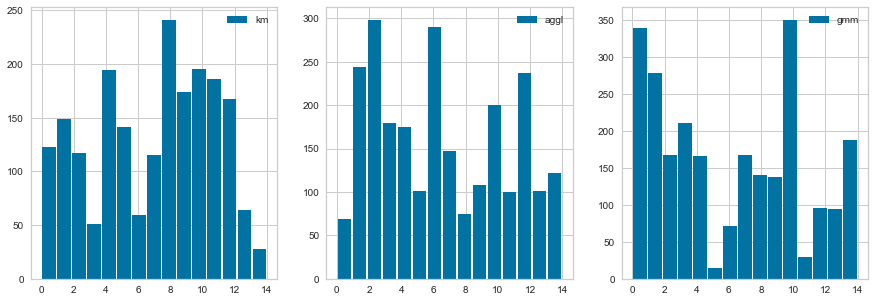

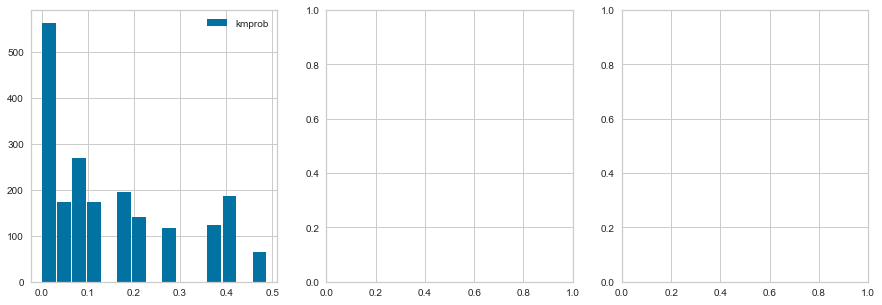

In [27]:


def plotclusterdist(df, features,clusters):
    for i in range(len(features)):
        if i % 3 == 0:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
            ax1.hist(df[df.enbloc==0][features[i]],bins=clusters,rwidth = 0.90, label=features[i])
            ax1.legend(loc = "best")
        elif i % 3 == 1:
            ax2.hist(df[features[i]], bins=clusters, rwidth = 0.90, label=features[i])
            ax2.legend(loc = "best")
        else:
            ax3.hist(df[features[i]], bins=clusters,rwidth = 0.90, label=features[i])
            ax3.legend(loc = "best")
            
plotclusterdist(results, results.columns[16:20],15)

<AxesSubplot:xlabel='gmm', ylabel='gmmprob'>

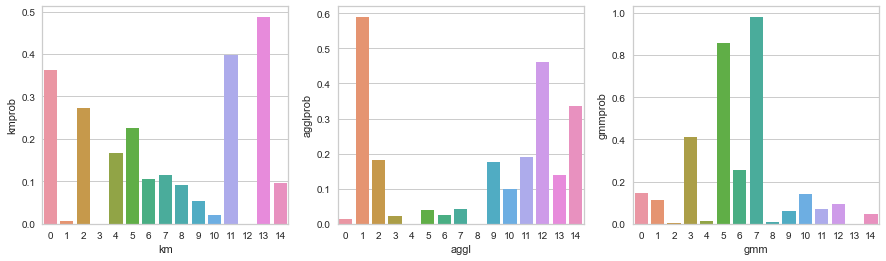

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

sns.barplot(x='km',y='kmprob',data=results, ax=ax1)
sns.barplot(x='aggl',y='agglprob',data=results, ax=ax2)
sns.barplot(x='gmm',y='gmmprob',data=results, ax=ax3)